In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Sun Jan 14 22:35:10 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   26C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [4]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.no_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.14-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 37284
-rw-rw-r-- 1 scpark scpark   200420  1월 14 19:50 events.out.tfevents.1705229221.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37976357  1월 14 19:47 save_0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


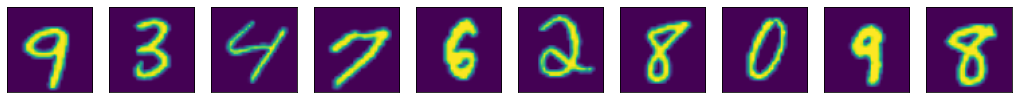

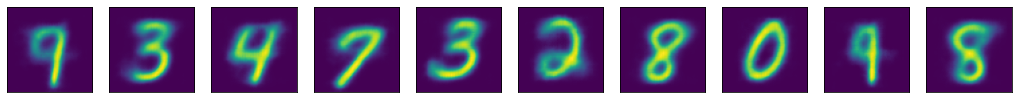

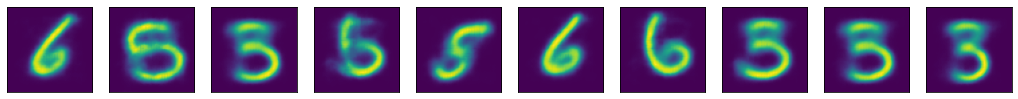

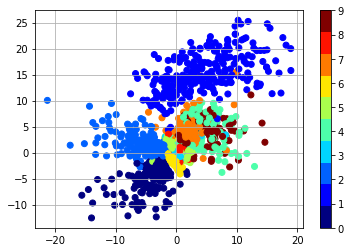

3001
recon_loss 0.1132587231695652
3002
recon_loss 0.1145803339779377
3003
recon_loss 0.11239006891846656
3004
recon_loss 0.11713124141097069
3005
recon_loss 0.11451955065131188
3006
recon_loss 0.11405892744660377
3007
recon_loss 0.1100838914513588
3008
recon_loss 0.10870141163468361
3009
recon_loss 0.11229480430483818
3010
recon_loss 0.10672908127307892
3011
recon_loss 0.10843856111168862
3012
recon_loss 0.11575232967734336
3013
recon_loss 0.10836275070905685
3014
recon_loss 0.10771043226122856
3015
recon_loss 0.11268899887800217
3016
recon_loss 0.11357075124979019
3017
recon_loss 0.11263583377003669
3018
recon_loss 0.11237117797136306
3019
recon_loss 0.10916523709893226
3020
recon_loss 0.11033234149217605
3021
recon_loss 0.10915886238217354
3022
recon_loss 0.10503850057721138
3023
recon_loss 0.10900002717971802
3024
recon_loss 0.10837395265698432
3025
recon_loss 0.10963556095957756
3026
recon_loss 0.10800701379776001
3027
recon_loss 0.11169620677828788
3028
recon_loss 0.1123489215970

recon_loss 0.1150007851421833
3231
recon_loss 0.10372990667819977
3232
recon_loss 0.11324171051383018
3233
recon_loss 0.11283878982067108
3234
recon_loss 0.11272858381271363
3235
recon_loss 0.11345498710870743
3236
recon_loss 0.11749089583754539
3237
recon_loss 0.11517399549484253
3238
recon_loss 0.10785052925348282
3239
recon_loss 0.1115917481482029
3240
recon_loss 0.11590841114521026
3241
recon_loss 0.10929675251245499
3242
recon_loss 0.10904254615306855
3243
recon_loss 0.11921353489160538
3244
recon_loss 0.11034440249204636
3245
recon_loss 0.1088527649641037
3246
recon_loss 0.1083618901669979
3247
recon_loss 0.11124454885721206
3248
recon_loss 0.10845135748386384
3249
recon_loss 0.11501865461468697
3250
recon_loss 0.11050588712096214
3251
recon_loss 0.10951837822794915
3252
recon_loss 0.11090740710496902
3253
recon_loss 0.11416814178228378
3254
recon_loss 0.11366990283131599
3255
recon_loss 0.10432622432708741
3256
recon_loss 0.10913749858736992
3257
recon_loss 0.1123944379389286
32

recon_loss 0.10431182384490967
3460
recon_loss 0.10528842881321906
3461
recon_loss 0.11070324182510376
3462
recon_loss 0.11751246228814125
3463
recon_loss 0.11563904285430908
3464
recon_loss 0.10699239671230316
3465
recon_loss 0.10827063471078872
3466
recon_loss 0.10649087876081467
3467
recon_loss 0.10577733218669891
3468
recon_loss 0.11133593618869782
3469
recon_loss 0.11365030631422997
3470
recon_loss 0.10605819001793862
3471
recon_loss 0.10557924956083298
3472
recon_loss 0.11276656240224839
3473
recon_loss 0.1156231589615345
3474
recon_loss 0.11747355684638024
3475
recon_loss 0.1166247434914112
3476
recon_loss 0.11642707884311676
3477
recon_loss 0.1152749352157116
3478
recon_loss 0.10652517229318618
3479
recon_loss 0.11241194307804107
3480
recon_loss 0.10696143954992295
3481
recon_loss 0.10727462843060494
3482
recon_loss 0.10933491960167885
3483
recon_loss 0.11651129201054573
3484
recon_loss 0.11165162846446038
3485
recon_loss 0.10659189075231552
3486
recon_loss 0.11065897867083549


recon_loss 0.11007559522986413
3689
recon_loss 0.11736141890287399
3690
recon_loss 0.10538002625107765
3691
recon_loss 0.10344699323177338
3692
recon_loss 0.1084748312830925
3693
recon_loss 0.10127522423863411
3694
recon_loss 0.11141209527850152
3695
recon_loss 0.1100249320268631
3696
recon_loss 0.11566592827439308
3697
recon_loss 0.11718678548932075
3698
recon_loss 0.10675743520259857
3699
recon_loss 0.10515755265951157
3700
recon_loss 0.11180045753717423
3701
recon_loss 0.11294551566243172
3702
recon_loss 0.11081705242395401
3703
recon_loss 0.11204190701246261
3704
recon_loss 0.11691484600305557
3705
recon_loss 0.11315331459045411
3706
recon_loss 0.10551338046789169
3707
recon_loss 0.11026637703180313
3708
recon_loss 0.10512301102280616
3709
recon_loss 0.10855760052800179
3710
recon_loss 0.10374776273965836
3711
recon_loss 0.11095521897077561
3712
recon_loss 0.11800825297832489
3713
recon_loss 0.10879565998911858
3714
recon_loss 0.10452332124114036
3715
recon_loss 0.11319630071520806

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        